# Metrics

Train Loss, Test Loss vs Epochs

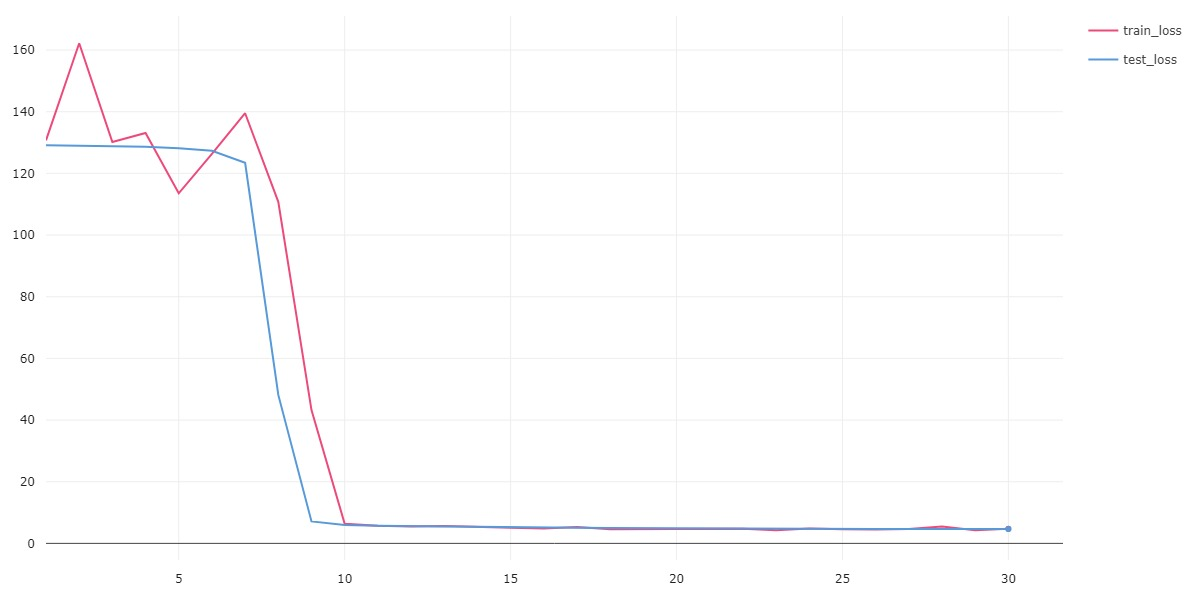


CER, WER

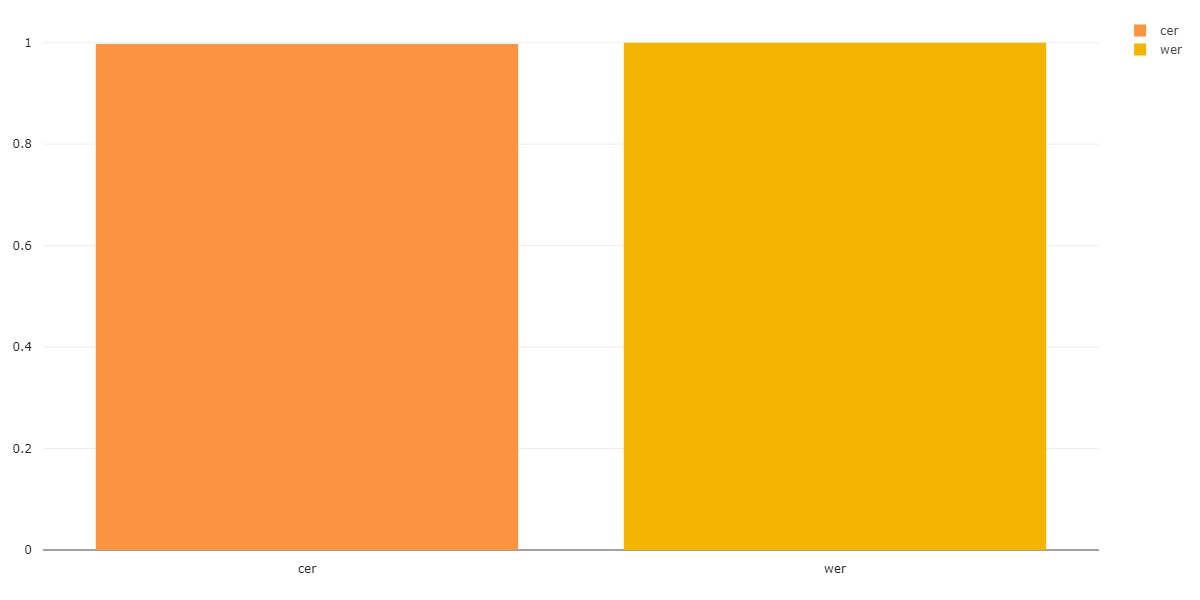


Test Loss vs Epochs

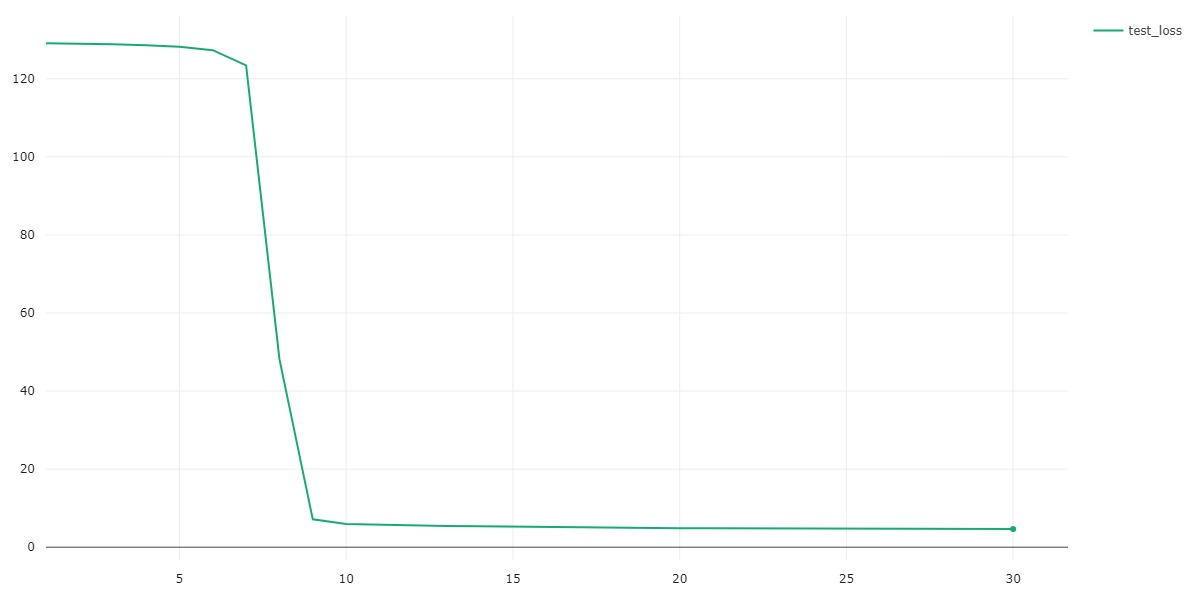

# Code

In [ ]:
!pip install comet-ml==3.0.2

     |████████████████████████████████| 170 kB 4.0 MB/s 
     |████████████████████████████████| 409 kB 52.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34546 sha256=168c3283355830ea9da457cfbee4a826d202e16b4bd664e4ba73dcb79345930a
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [ ]:
!nvidia-smi

In [ ]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Union
from torch import Tensor

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, annotations_file, audio_dir):
    self.annotations = pd.read_csv(annotations_file, encoding='utf-8')
    self.audio_dir = audio_dir

  def __len__(self):
    return len(self.annotations)

  def _get_file_name(self, index):
    return self.annotations.iloc[index, 0]

  def _get_label(self, index):
    return self.annotations.iloc[index, 2]


  def __getitem__(self, index) -> Tuple[Tensor, str]:
    file_name = self._get_file_name(index)
    audio_sample_path = os.path.join(self.audio_dir, file_name)
    audio_sample_path = audio_sample_path + ".wav"
    label = self._get_label(index)
    signal, sr = torchaudio.load(audio_sample_path)
    return (signal, label)

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
ঀ 0
ঁ 1
ং 2
ঃ 3
অ 4
আ 5
ই 6
ঈ 7
উ 8
ঊ 9
ঋ 10
ঌ 11
এ 12
ঐ 13
ও 14
ঔ 15
ক 16
খ 17
গ 18
ঘ 19
ঙ 20
চ 21
ছ 22
জ 23
ঝ 24
ঞ 25
ট 26
ঠ 27
ড 28
ঢ 29
ণ 30
ত 31
থ 32
দ 33
ধ 34
ন 35
প 36
ফ 37
ব 38
ভ 39
ম 40
য 41
র 42
ল 43
শ 44
ষ 45
স 46
হ 47
় 48
ঽ 49
া 50
ি 51
ী 52
ু 53
ূ 54
ৃ 55
ৄ 56
ে 57
ৈ 58
ো 59
ৌ 60
্ 61
ৎ 62
ৗ 63
ড় 64
ঢ় 65
য় 66
ৠ 67
০ 68
১ 69
২ 70
৩ 71
৪ 72
৫ 73
৬ 74
৭ 75
৮ 76
৯ 77
ৱ 78
৲ 79
৴ 80
<SPACE> 81
: 82
\u200c 83
\u200d 84
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[81] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')




train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

def train_data_processing(data):
    spectro = []

    labels = []



    input_lengths = []
    
    label_lengths = []
    
    for (signal, label) in data:
      spec = train_audio_transforms(signal).squeeze(0).transpose(0, 1)
      spectro.append(spec)
      _label = torch.Tensor(text_transform.text_to_int(label))
      labels.append(_label)
      input_lengths.append(spec.shape[0]//2)
      label_lengths.append(len(label))

            

    spectro = nn.utils.rnn.pad_sequence(spectro, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True) 

    return spectro, labels, input_lengths, label_lengths




def test_data_processing(data):
    spectro = []

    labels = []



    input_lengths = []
    
    label_lengths = []
    
    for (signal, label) in data:
      spec = test_audio_transforms(signal).squeeze(0).transpose(0, 1)
      spectro.append(spec)
      _label = torch.Tensor(text_transform.text_to_int(label))
      labels.append(_label)
      input_lengths.append(spec.shape[0]//2)
      label_lengths.append(len(label))

            

    spectro = nn.utils.rnn.pad_sequence(spectro, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True) 

    return spectro, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=85, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets


In [ ]:
class CNNBatchNorm(nn.Module):
    """Bacth normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNBatchNorm, self).__init__()
        self.batch_norm = nn.BatchNorm2d(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.batch_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        #self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        #self.dropout2 = nn.Dropout(dropout)
        self.batch_norm1 = CNNBatchNorm(in_channels)   # these adj two has been edited 
        #self.bacth_norm2 = CNNBatchNorm(in_channels)   # these adj two has been edited 

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.batch_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        #x = self.batch_norm2(x)
        #x = F.gelu(x)
        #x = self.dropout2(x)
        #x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalLSTM(nn.Module):    # needs to be edited

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalLSTM, self).__init__()

        self.BiLSTM = nn.LSTM(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.gelu(x)
        x, _ = self.BiLSTM(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalLSTM(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
    with experiment.train():
        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            experiment.log_metric('loss', loss.item(), step=epoch)
            experiment.log_metric('learning_rate', scheduler.get_lr(), step=epoch)

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 1 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with experiment.test():
        with torch.no_grad():
            for i, _data in enumerate(test_loader):
                spectrograms, labels, input_lengths, label_lengths = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)

                output = model(spectrograms)  # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) # (time, batch, n_class)

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    experiment.log_metric('test_loss', test_loss, step=epoch)
    experiment.log_metric('cer', avg_cer, step=epoch)
    experiment.log_metric('wer', avg_wer, step=epoch)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate=5e-4, batch_size=20, epochs=10,
        experiment=Experiment(api_key='dummy_key', disabled=True)):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 86,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    experiment.log_parameters(hparams)

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    #if not os.path.isdir("./data"):
        #os.makedirs("./data")

    test_file = "/content/drive/MyDrive/test-data/ex_test_data.csv"
    test_file_dir = "/content/drive/MyDrive/test-data"

    test_dataset = CustomDataset(test_file, test_file_dir)

    train_file = "/content/drive/MyDrive/train-data/ex_train_data.csv"
    train_file_dir = "/content/drive/MyDrive/train-data"

    train_dataset = CustomDataset(train_file, train_file_dir)

    #for i in range(len(custom_dataset)):
    #  sample = custom_dataset[i]
    # print(i, sample)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: train_data_processing(x),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: test_data_processing(x),
                                **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=37).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment)
        test(model, device, test_loader, criterion, epoch, iter_meter, experiment)

In [ ]:
comet_api_key = "wHEuNdW5zt9RmE6k0gAVNAsuU" # add your api key here
project_name = "speechrecognitionbangla"
experiment_name = "CNN-RNN(LSTM)"

if comet_api_key:
  experiment = Experiment(api_key=comet_api_key, project_name=project_name, parse_args=False)
  experiment.set_name(experiment_name)
  experiment.display()
else:
  experiment = Experiment(api_key='dummy_key', disabled=True)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rhr190/speechrecognitionbangla/0aeb2f1ee90c4ce999eec839d51e1d12



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
learning_rate = 1e-5
batch_size = 32
epochs = 30


main(learning_rate, batch_size, epochs, experiment)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (batch_norm1): CNNBatchNorm(
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (batch_norm1): CNNBatchNorm(
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (batch_norm1): CNNBatchNorm(
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1565: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train Epoch: 1 [0/640 (0%)]	Loss: 130.704956
Train Epoch: 1 [32/640 (5%)]	Loss: 134.164154
Train Epoch: 1 [64/640 (10%)]	Loss: 134.362930
Train Epoch: 1 [96/640 (15%)]	Loss: 137.174255
Train Epoch: 1 [128/640 (20%)]	Loss: 117.079605
Train Epoch: 1 [160/640 (25%)]	Loss: 143.335068
Train Epoch: 1 [192/640 (30%)]	Loss: 118.945297
Train Epoch: 1 [224/640 (35%)]	Loss: 135.787079
Train Epoch: 1 [256/640 (40%)]	Loss: 121.906311
Train Epoch: 1 [288/640 (45%)]	Loss: 104.731796
Train Epoch: 1 [320/640 (50%)]	Loss: 110.214691
Train Epoch: 1 [352/640 (55%)]	Loss: 125.016365
Train Epoch: 1 [384/640 (60%)]	Loss: 113.906471
Train Epoch: 1 [416/640 (65%)]	Loss: 117.562965
Train Epoch: 1 [448/640 (70%)]	Loss: 122.569664
Train Epoch: 1 [480/640 (75%)]	Loss: 109.786003
Train Epoch: 1 [512/640 (80%)]	Loss: 132.866486
Train Epoch: 1 [544/640 (85%)]	Loss: 142.795151
Train Epoch: 1 [576/640 (90%)]	Loss: 106.169281
Train Epoch: 1 [608/640 (95%)]	Loss: 126.629005

evaluating...
Test set: Average loss: 129.1200

# FOR EXPERIMENT PURPOSE

In [ ]:
#convert bangla character to number value
char_map_str = """
<SPACE> 0
ঁ 1
ং 2
ঃ 3
অ 4
আ 5
ই 6
ঈ 7
উ 8
ঊ 9
ঋ 10
ঌ 11
এ 12
ঐ 13
ও 14
ঔ 15
ক 16
খ 17
গ 18
ঘ 19
ঙ 20
চ 21
ছ 22
জ 23
ঝ 24
ঞ 25
ট 26
ঠ 27
ড 28
ঢ 29
ণ 30
ত 31
থ 32
দ 33
ধ 34
ন 35
প 36
ফ 37
ব 38
ভ 39
ম 40
য 41
র 42
ল 43
শ 44
ষ 45
স 46
হ 47
া 48
ি 49
ী 50
ু 51
ূ 52
ৃ 53
ৄ 54
ে 55
ৈ 56
ো 57
ৌ 58
্ 59
ৎ 60
ৗ 61
ড় 62
ঢ় 63
য় 64
ৠ 65
০ 66
১ 67
২ 68
৩ 69
৪ 70
৫ 71
৬ 72
৭ 73
৮ 74
৯ 75
: 76
"""
# the "blank" character is mapped to 84
char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[0] = ' '

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence


def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return ''.join(text).replace('<SPACE>', ' ')

print(index_map[0])

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
ঁ 1
ং 2
ঃ 3
অ 4
আ 5
ই 6
ঈ 7
উ 8
ঊ 9
ঋ 10
ঌ 11
এ 12
ঐ 13
ও 14
ঔ 15
ক 16
খ 17
গ 18
ঘ 19
ঙ 20
চ 21
ছ 22
জ 23
ঝ 24
ঞ 25
ট 26
ঠ 27
ড 28
ঢ 29
ণ 30
ত 31
থ 32
দ 33
ধ 34
ন 35
প 36
ফ 37
ব 38
ভ 39
ম 40
য 41
র 42
ল 43
শ 44
ষ 45
স 46
হ 47
া 48
ি 49
ী 50
ু 51
ূ 52
ৃ 53
ৄ 54
ে 55
ৈ 56
ো 57
ৌ 58
্ 59
ৎ 60
ৗ 61
ড় 62
ঢ় 63
য় 64
ৠ 65
০ 66
১ 67
২ 68
৩ 69
৪ 70
৫ 71
৬ 72
৭ 73
৮ 74
৯ 75
: 76
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')




train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

def train_data_processing(data):
    spectro = []

    labels = []



    input_lengths = []
    
    label_lengths = []
    
    for (signal, label) in data:
      spec = train_audio_transforms(signal).squeeze(0).transpose(0, 1)
      spectro.append(spec)
      _label = torch.Tensor(text_transform.text_to_int(label))
      labels.append(_label)
      input_lengths.append(spec.shape[0]//2)
      label_lengths.append(len(label))

            

    spectro = nn.utils.rnn.pad_sequence(spectro, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True) 

    return spectro, labels, input_lengths, label_lengths




def test_data_processing(data):
    spectro = []

    labels = []



    input_lengths = []
    
    label_lengths = []
    
    for (signal, label) in data:
      spec = test_audio_transforms(signal).squeeze(0).transpose(0, 1)
      spectro.append(spec)
      _label = torch.Tensor(text_transform.text_to_int(label))
      labels.append(_label)
      input_lengths.append(spec.shape[0]//2)
      label_lengths.append(len(label))

            

    spectro = nn.utils.rnn.pad_sequence(spectro, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True) 

    return spectro, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=37, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets
